### This notebook serves as extracting the final evaluation metrics for the trained models (both with pretrained weights nad unpretrained weights

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
from util_datasets import GaussianNoise, UniformNoise
import csv
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

%load_ext autoreload

%autoreload 2


use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")


class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

imgtransResize = (320, 320)
imgtransCrop = 224

from trainer import CheXpertTrainer 
from chexpertClass import CheXpertData
from denseNet121 import DenseNet121
from utils import *
# from ood_evaluate import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
####################
# These utility functions are burrowed from utils.py in GPU VM instance
####################

def load_checkpoint_v2(checkpoint_path, model, optimizer, use_cuda):
    if use_cuda:
        state = torch.load(checkpoint_path)
    else:
        state = torch.load(checkpoint_path, map_location='cpu')
   
    model_state = state['state_dict']
    optim_state = state['optimizer']
    train_loss = state['train_losses']
    eval_loss = state['eval_losses']
    auroc_scores = state['aurocResults']
    labels = state['labels']
    scores = state['predictions']
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optim_state)
    
    print('model loaded from %s' % checkpoint_path)
    
    return train_loss, eval_loss, labels, scores

def evaluate_ood(data_loader, mode, model, device):
    model.eval()
    outPred = []
    outGround = []
    outConf = []
    bxent = nn.BCELoss(reduction = 'mean')
    
    progress_bar = tqdm(data_loader)
    
    for i, (images,labels) in enumerate(progress_bar):
        
        if type(labels) == list:
            #print("Chestnet being evaluated...")
            labels = torch.stack(labels).float().transpose(0,1).to(device)
        #else:
            #print("NIH being evaluated...")


        bs, c, h, w = images.size()
        varInput = images.view(-1, c, h, w)
        
        outGround.append(labels.cpu().numpy())

        if mode == 'confidence':
            with torch.no_grad():
                preds, confidence = model(varInput)
                confidence = torch.sigmoid(confidence)
                confidence = confidence.data.cpu().numpy()
                outPred.append(preds.data.cpu().numpy())
                outConf.append(confidence)

        elif mode == 'confidence_scaling':
            epsilon = 0.001  ##value needs to be determined (noise magnitude) 

            model.zero_grad()
            varInput.requires_grad_()
            
            _,confidence = model(varInput)
            confidence = torch.sigmoid(confidence)
            loss = torch.mean(-torch.log(confidence))
            loss.backward()

            varInput = varInput - epsilon * torch.sign(varInput.grad)

            preds,confidence = model(varInput)
            confidence = torch.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            outPred.append(preds.data.cpu().numpy())
            outConf.append(confidence)


        elif mode == 'baseline':
            with torch.no_grad():
                pred, _ = model(varInput)
                pred = pred.cpu().numpy()
                outPred.append(pred)

        elif mode == 'odin':
            T = 1000  #this hyperparameter can also be experimeted
            epsilon = 0.001

            model.zero_grad()
            pred,_ = model(varInput)
            pred /= T
            loss = bxent(pred, labels)
            loss.backward()

            varInput = varInput - epsilon * torch.sign(varInput.grad)
            pred,_ = model(varInput)

            #might need to take Sigmoid layer out from the model class for ODIN

            pred = pred.data.cpu().numpy()
            outPred.append(pred)
            
            
    outPred = np.concatenate(outPred)
    outGround = np.concatenate(outGround)
    outConf = np.concatenate(outConf)
    return outPred, outGround, outConf

In [3]:
#TRANSFORM DATA SEQUENCE
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

#CheXpert dataset loading
chex_datasetValid = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/valid.csv',transformSequence, preload = True, policy="ones")
chex_datasetTrain = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/train.csv',transformSequence, policy="ones")
print("Train set: ", len(chex_datasetTrain))
print("Valid set: ", len(chex_datasetValid))
datasetValid, datasetTrain = random_split(chex_datasetTrain, [766, len(chex_datasetTrain) - 766])
chex_test, chex_train = random_split(datasetTrain, [1000, len(datasetTrain) - 1000])

#split datasets into train,valid,test
chex_valid = torch.utils.data.ConcatDataset([chex_datasetValid, datasetValid])
print("New train set: ", len(chex_train))
print("New valid set: ", len(chex_valid))
print("New test set: ", len(chex_test))
dataLoaderTrain = DataLoader(dataset=chex_train, batch_size=16, shuffle=True,  num_workers=1, pin_memory=True)
dataLoaderValid = DataLoader(dataset=chex_valid, batch_size=16, shuffle=False,  num_workers=1, pin_memory=True)
dataLoaderTest = DataLoader(dataset=chex_test, batch_size=16, shuffle=False,  num_workers=0, pin_memory=True)

#NIH dataset loading
nih_dataset = datasets.ImageFolder(root='datasets/nih-small/small', transform = transformSequence)
nih_test, nih_train = random_split(nih_dataset, [1000, len(nih_dataset) - 1000])
print("NIH train set: ", len(nih_train))
print("NIH valid set: ", len(nih_test))
dataLoaderNIH = DataLoader(dataset=nih_test, batch_size=16, shuffle=False,  num_workers=0, pin_memory=True)

Train set:  223414
Valid set:  234
New train set:  221648
New valid set:  1000
New test set:  1000
NIH train set:  4606
NIH valid set:  1000


#### Evaluation for the model with pretrained weights

In [4]:
model = DenseNet121(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path1 = 'checkpoints/epoch1.pth.tar'
checkpoint_path2 = 'checkpoints/epoch2.pth.tar'
checkpoint_path3 = 'checkpoints/epoch3.pth.tar'
train_v1_loss, eval_v1_loss, labels_v1, preds_v1 = load_checkpoint_v2(checkpoint_path3, model, optimizer, use_cuda)

model loaded from checkpoints/epoch3.pth.tar


In [9]:
ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'confidence', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'confidence', model, device)

ood_gt = np.zeros((ood_scores.shape[0], ood_scores.shape[1]))
labels = np.concatenate([ind_gt, ood_gt])
scores = np.concatenate([ind_scores, ood_scores])
confidences = np.concatenate([ind_conf,ood_conf])
ind_conf_labels = np.ones(ind_scores.shape[0])
ood_conf_labels = np.zeros(ood_scores.shape[0])
conf_labels = np.concatenate([ind_conf_labels,ood_conf_labels])

100%|██████████| 63/63 [46:10<00:00, 37.47s/it]



Method: confidence
TPR75 (lower is better):  0.9347499999999878
Detection error (lower is better):  0.5
Best threshold: 0.6241537928581238
AUROC (higher is better):  0.274096
AUPR_IN (higher is better):  0.3662906445791707
AUPR_OUT (higher is better):  0.3681440388854611


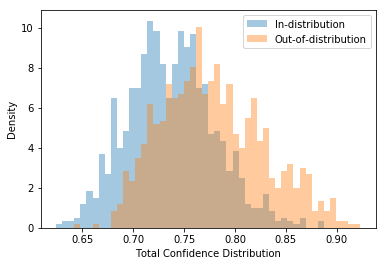

In [13]:
fpr = tpr76(ind_conf, ood_conf)
detection_error, best_delta = detection(ind_conf, ood_conf)
auroc = metrics.roc_auc_score(conf_labels, confidences)
aupr_in = metrics.average_precision_score(conf_labels, confidences)
aupr_out = metrics.average_precision_score(-1 * conf_labels + 1, 1 - confidences)

print("")
print("Method: confidence")
print("TPR75 (lower is better): ", fpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)
        
ranges = (np.min(confidences), np.max(confidences))
sns.distplot(ind_conf.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
sns.distplot(ood_conf.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()